In [282]:
import pandas as pd
import json
import numpy as np
import ydata_profiling

In [283]:
#we only need 3 columns in review.json. Since the file is so big (5GB!) we will avoid opening the whole JSON file
#and instead append to a list and then make it into a dataframe

#ADD IN REVIEW JSON

chunk = []
columns = ["user_id", "business_id", "stars"] #For the collaborative filtering approach, we may add back stars

with open("/Users/dariayip/Documents/vs code/yelp_academic_dataset_review.json", "r") as y:
    for line in y:
        doc = json.loads(line)
        lst = [doc["user_id"], doc["business_id"], doc["stars"]]
        #lst = [doc["user_id"], doc["business_id"], doc["text"], doc["stars"]]
        chunk.append(lst)

review = pd.DataFrame(data=chunk, columns=columns)

In [284]:
business_dtypes = {"business_id" : str, "name" : str, "address" : str, "city" : str, "state" : str, "postal_code" : str,
                  "latitude" : float, "longitude" : float, "stars" : float, "review_count" : int, "is_open" : int,
                  "attributes" : str, "categories" : str, "hours" : str}

#Open the Business JSON, with orient as columns --> values in that ordered pair
with open("/Users/dariayip/Documents/vs code/yelp_academic_dataset_business.json", "r") as y:
    business = pd.read_json(y, orient="records", lines = True, dtype = business_dtypes) #save as a business df
    
#rename stars to avoid confusion
business = business.rename(columns = {"stars": "stars_business"})

In [285]:
#perform a left join to get the businesses with reviews and add the columns in the business 
businesseswithreviews = pd.merge(review, business, on = "business_id", how = "left")
print(businesseswithreviews.head(5))
print(businesseswithreviews.describe)
#print(businesseswithreviews.app)
print(businesseswithreviews.agg)
print(businesseswithreviews.shape)


                  user_id             business_id  stars  \
0  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw    3.0   
1  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ    5.0   
2  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A    3.0   
3  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA    5.0   
4  bcjbaE6dDog4jkNY91ncLQ  e4Vwtrqf-wpJfwesgvdgxQ    4.0   

                           name                   address          city state  \
0  Turning Point of North Wales       1460 Bethlehem Pike   North Wales    PA   
1    Body Cycle Spinning Studio  1923 Chestnut St, 2nd Fl  Philadelphia    PA   
2             Kettle Restaurant     748 W Starr Pass Blvd        Tucson    AZ   
3                         Zaika            2481 Grant Ave  Philadelphia    PA   
4                          Melt             2549 Banks St   New Orleans    LA   

  postal_code   latitude   longitude  stars_business  review_count  is_open  \
0       19454  40.210196  -75.223639             3.0           169       

Text(0.5, 1.0, 'Top 50 Cities with the most businesses')

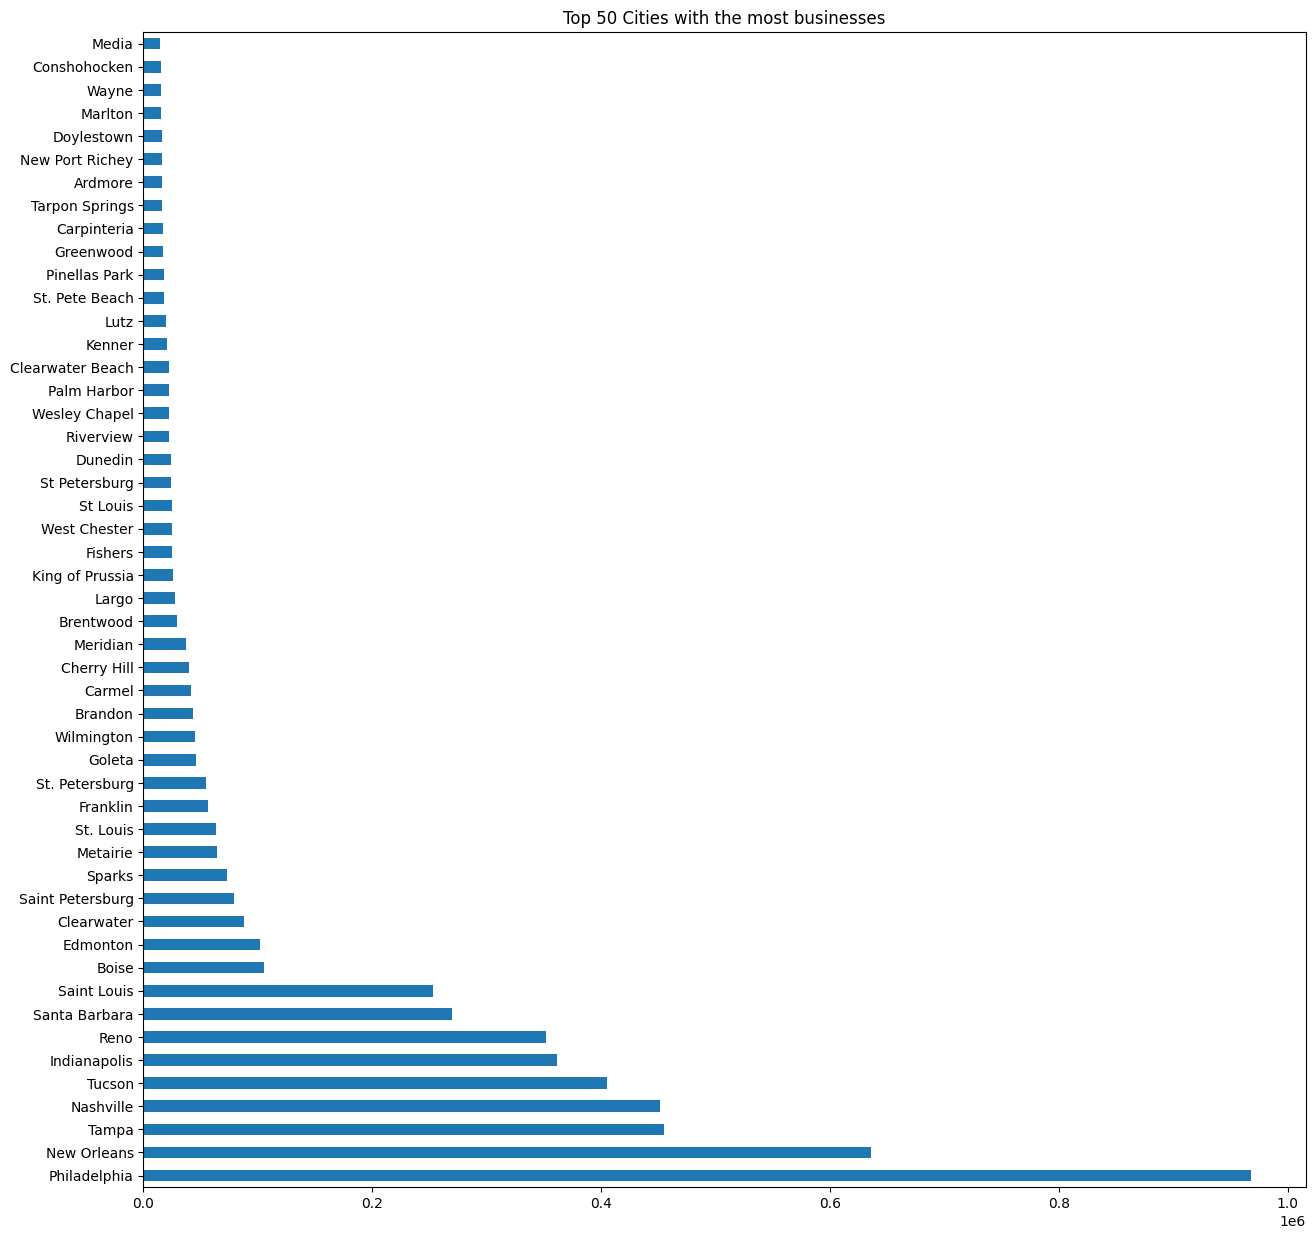

In [286]:
#Visualize the distribution
import matplotlib.pyplot as plt
#Visualize the city with the most businesses (that have at least one review)

top50citiesbybusinesses = businesseswithreviews.city.value_counts().sort_values(ascending = False)[0:50] 
#plot histogram of how many cities there are with businesses that have reviews to see top 50 with most businesses

top50citiesbybusinesses.plot(kind="barh", figsize=[15,15]) 
plt.title("Top 50 Cities with the most businesses")

Text(0.5, 1.0, 'Top 50 Cities by Reviews')

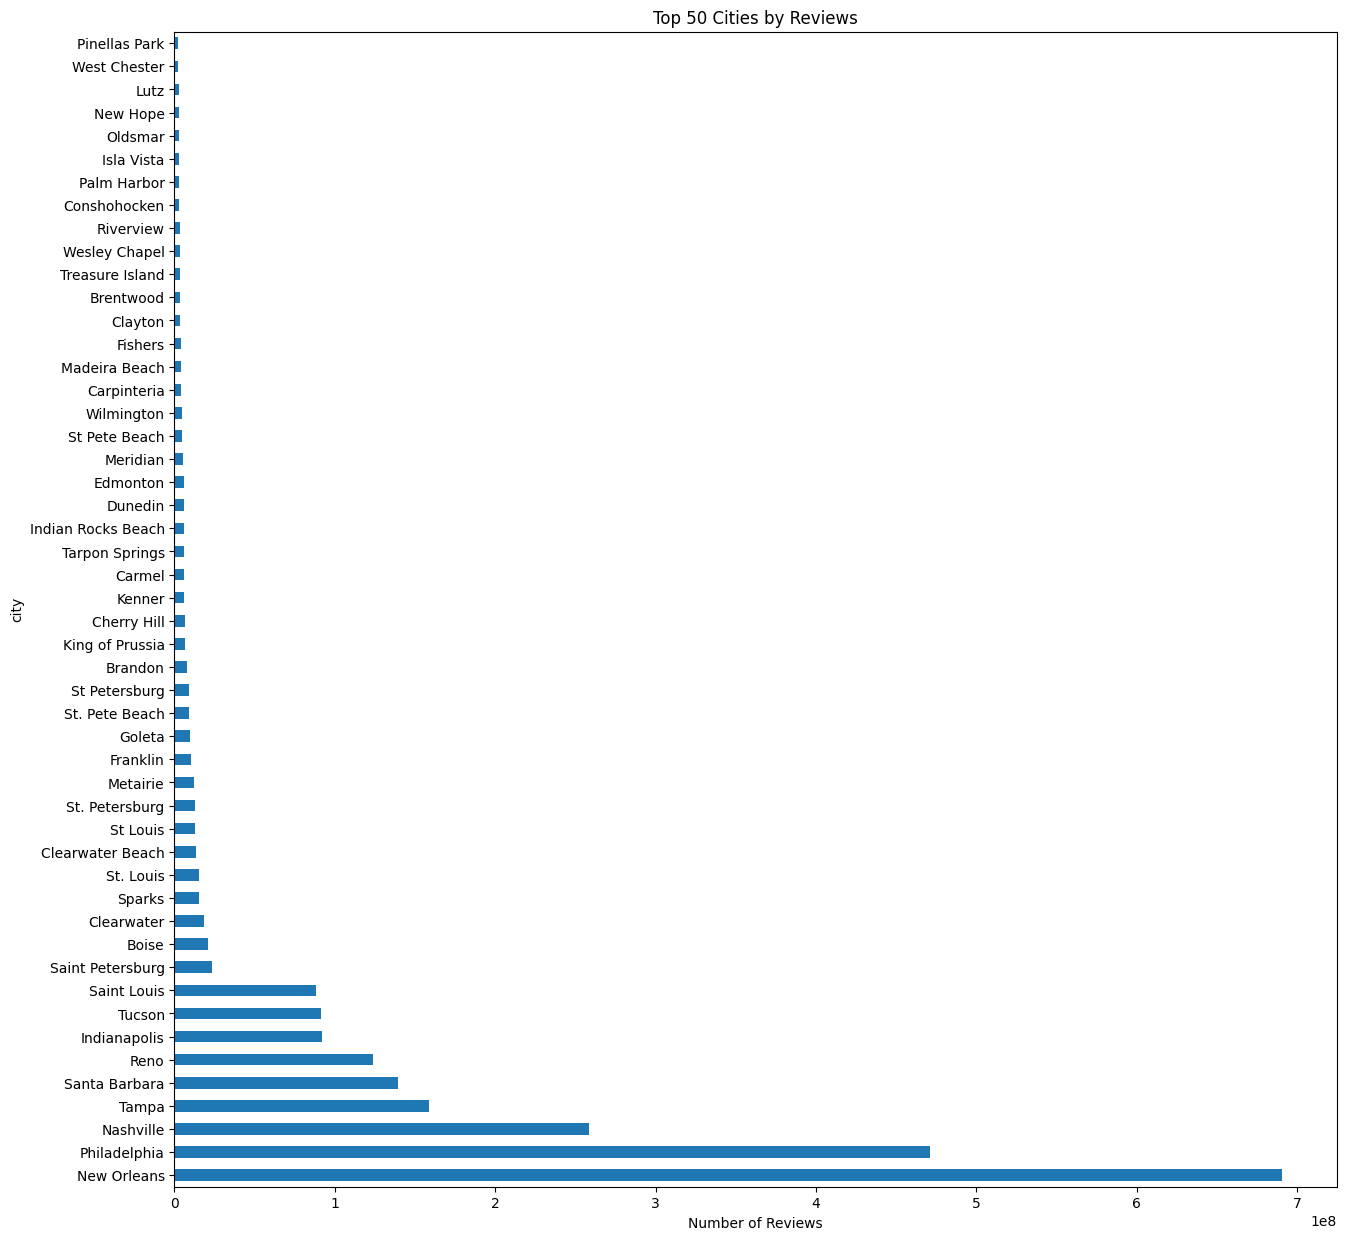

In [287]:
#Visualize the city with the most reviews
import matplotlib.pyplot as plt

top50citiesbyreviews = businesseswithreviews.groupby('city')['review_count'].sum() #calculate top 50 cities by review count

# Sort the grouped data in descending order
sorteddata = top50citiesbyreviews.sort_values(ascending = False)

# Select the top 50 cities
top50citiesbyreviews = sorteddata.head(50)

top50citiesbyreviews.plot(kind="barh", figsize=[15,15]) #bar graph with a square shape, 15x15
plt.xlabel('Number of Reviews') #give a label for the x-axis
plt.title("Top 50 Cities by Reviews") #give a label for the title of the graph

In [288]:
print(top50citiesbyreviews) #counts for top 50 cities by reviews

city
New Orleans           690175628
Philadelphia          471093433
Nashville             258333400
Tampa                 158454061
Santa Barbara         139164771
Reno                  123979688
Indianapolis           92167266
Tucson                 91518957
Saint Louis            88563175
Saint Petersburg       23310811
Boise                  20675630
Clearwater             18660630
Sparks                 15576640
St. Louis              15415298
Clearwater Beach       13494651
St Louis               12788208
St. Petersburg         12702883
Metairie               12009085
Franklin               10258575
Goleta                 10029809
St. Pete Beach          8968893
St Petersburg           8958630
Brandon                 8106153
King of Prussia         6635677
Cherry Hill             6360902
Kenner                  6077564
Carmel                  6046640
Tarpon Springs          5808352
Indian Rocks Beach      5756113
Dunedin                 5753482
Edmonton                5750609
Mer

In [289]:
#Downsampling

businesseswithreviews = businesseswithreviews[businesseswithreviews["is_open"] == 1] #drop any businesses that are no longer operational
businesseswithreviews = businesseswithreviews[businesseswithreviews["categories"].str.contains("Restaurants", na=False)] #Delete any businesses that do not include the word "Restaurants" within the Categories section

In [290]:
#Downsampling Part 2

businesseswithreviews = businesseswithreviews[businesseswithreviews["city"] == "Philadelphia"] #filter out any cities other than Philadelphia (most businesses by city)
print(businesseswithreviews.shape)

counts_business_ID = businesseswithreviews.groupby("business_id")["business_id"].transform(len)
mask = (counts_business_ID > 5)
businesseswithreviews = businesseswithreviews[mask]
#remove businesses with less than 5 

(511138, 16)


In [291]:
counts_business_ID = businesseswithreviews.groupby("business_id")["business_id"].transform(len)
mask = (counts_business_ID > 20)
businesseswithreviews = businesseswithreviews[mask]
businesseswithreviews.shape

(499171, 16)

In [292]:
#Systematic Sampling (removing every 10th row)
businesseswithreviews = businesseswithreviews[businesseswithreviews.index % 10 != 0] 
businesseswithreviews.shape

(448906, 16)

In [293]:
#Random Sampling of 20% of dataset
businesseswithreviews = businesseswithreviews.sample(frac=0.20)
businesseswithreviews.shape

(89781, 16)

In [294]:
#Detect any missing data
missingdata = businesseswithreviews.isnull().sum() #sum up the amount of missing data points in this dataframe
print(missingdata)

user_id           0
business_id       0
stars             0
name              0
address           0
city              0
state             0
postal_code       0
latitude          0
longitude         0
stars_business    0
review_count      0
is_open           0
attributes        0
categories        0
hours             0
dtype: int64


In [295]:
#Detect any missing data
missingdata = business.isnull().sum() #sum up the amount of missing data points in this dataframe
print(missingdata)

business_id       0
name              0
address           0
city              0
state             0
postal_code       0
latitude          0
longitude         0
stars_business    0
review_count      0
is_open           0
attributes        0
categories        0
hours             0
dtype: int64


In [296]:
#Detect any missing data
missingdata = review.isnull().sum() #sum up the amount of missing data points in this dataframe
print(missingdata)

user_id        0
business_id    0
stars          0
dtype: int64


In [297]:
businesseswithreviews.shape #let's see how many rows and columns we have now!

(89781, 16)

In [298]:
#Pandas Profile for the businesseswithreviews dataset
profile = ydata_profiling.ProfileReport(businesseswithreviews)
profile.to_file(output_file="businesseswithreviewsEDAprofile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [299]:
#Split the dataset into train and test sets before we preprocess the data
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(businesseswithreviews, test_size=0.2) #80% train, 20% test

In [300]:
#Visualize what the two sets look like
df_train.shape

(71824, 16)

In [301]:
#Visualize the training dataset first 5 rows
df_train.head(5)

,user_id,business_id,stars,name,address,city,state,postal_code,latitude,longitude,stars_business,review_count,is_open,attributes,categories,hours
4024833,h_2gtzMu36xsjxuWbIuV6w,SPEXSaryxJmVpy8QoRz7Tg,5.0,Vietnam Cafe,816 S 47th St,Philadelphia,PA,19143,39.948178,-75.216887,4.0,357,1,"{'GoodForKids': 'True', 'BusinessAcceptsCredit...","Vietnamese, Restaurants","{'Monday': '11:30-20:0', 'Tuesday': '11:30-20:..."
5958882,AwOiHTSFfXYY0Ra_CyaVIw,9PZxjhTIU7OgPIzuGi89Ew,5.0,El Vez,121 S 13th St,Philadelphia,PA,19107,39.949702,-75.161770,4.0,3187,1,"{'RestaurantsReservations': 'True', 'BYOBCorka...","Lounges, Bars, Nightlife, Breakfast & Brunch, ...","{'Monday': '0:0-0:0', 'Tuesday': '12:0-22:0', ..."
6550745,yYSc16a8eY-Rt-j7sUbGYw,wPi7p5fZyGTOjDU28IlTqA,4.0,Woody's,202 S 13th St,Philadelphia,PA,19107,39.949064,-75.162410,3.0,325,1,"{'BusinessParking': ""{'garage': False, 'street...","Restaurants, Bars, American (Traditional), Gay...","{'Monday': '19:0-2:0', 'Tuesday': '19:0-2:0', ..."
2339198,t0zwvk2Ll1OvBD-1yqoXxQ,IkY2ticzHEn4QFn8hQLSWg,3.0,Geno's Steaks,1219 S 9th St,Philadelphia,PA,19147,39.933837,-75.158814,2.5,3401,1,"{'RestaurantsReservations': 'False', 'Corkage'...","Sandwiches, Cheesesteaks, Steakhouses, Restaur...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."
2323632,eXj2MwsPxUAWLoLOC3EenA,ZGChyjzwb_buWTT6Wg-q7g,5.0,Ahi Sushi,9999 Bustleton Ave,Philadelphia,PA,19115,40.102460,-75.028764,4.0,122,1,"{'BusinessParking': ""{'garage': False, 'street...","Japanese, Sushi Bars, Restaurants","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."


In [302]:
df_test.shape #visualize the test dataframe

(17957, 16)

In [303]:
#Creating a pivottable where name will be the row and text will be the column
#Using the JOIN function to join the text strings together into one string
business_reviews = pd.pivot_table(df_train, values=["categories"], index=["name"], columns=[], aggfunc=" ".join)
#business_reviews = pd.pivot_table(df_train, values=["text"], index=["name"], columns=[], aggfunc=" ".join)

business_reviews
#Visualize

,categories
name,
&pizza - UPenn,"Vegetarian, Vegan, Restaurants, Pizza Vegetari..."
&pizza - Walnut,"Pizza, Vegetarian, Restaurants, Vegan Pizza, V..."
1100 Social,"Bars, Nightlife, Restaurants, American (New) B..."
1225Raw Sushi and Sake Lounge,"Japanese, Restaurants, Korean, Sushi Bars Japa..."
13 Restaurant,"American (New), Nightlife, American (Tradition..."
...,...
la bamba,"Tacos, Restaurants, Mexican Tacos, Restaurants..."
moonbowls,"Vegetarian, Restaurants, Gluten-Free, Korean V..."
nunu,"Restaurants, Nightlife, Bars, Japanese Restaur..."


In [304]:
from sklearn.feature_extraction.text import TfidfVectorizer    

#tfidf = TfidfVectorizer(stop_words = "english", ngram_range = (2,2)) #stating the stop words as English and make it bigram analysis
tfidf = TfidfVectorizer(stop_words = "english") #stating the stop words as English and keeping as unigram

tfidf_matrix = tfidf.fit_transform(business_reviews["categories"]) #fit_transform the business review's column text and 
#get the vectors
#tfidf_matrix = tfidf.fit_transform(business_reviews["text"]) #fit_transform the business review's column text and 

In [305]:
from sklearn.metrics.pairwise import cosine_similarity
#from sklearn.metrics.pairwise import euclidean_distances

cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix) #create the cosine_similarities matrix of 
#item to item similarity
#euclidean_distance = euclidean_distances(tfidf_matrix)

In [306]:
cosine_similarities #Visualize


array([[1.        , 0.30140815, 0.        , ..., 0.        , 0.        ,
        0.13479731],
       [0.30140815, 1.        , 0.        , ..., 0.        , 0.        ,
        0.10404444],
       [0.        , 0.        , 1.        , ..., 0.        , 0.12831182,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.12831182, ..., 0.        , 1.        ,
        0.01993278],
       [0.13479731, 0.10404444, 0.        , ..., 0.        , 0.01993278,
        1.        ]])

In [307]:
#euclidean_distance #Visualize

In [308]:
#Rename the index column to "name" and reset the index to #s
business_reviews = business_reviews.reset_index().rename(columns={"name": "business_name"})

#Add another column to represent the "name" column
business_reviews["name"] = business_reviews["business_name"]
#business_reviews = business_reviews.drop(columns = ["business_name"]) #drop the extra column name

business_reviews.head(5) #Visualize this

,business_name,categories,name
0,&pizza - UPenn,"Vegetarian, Vegan, Restaurants, Pizza Vegetari...",&pizza - UPenn
1,&pizza - Walnut,"Pizza, Vegetarian, Restaurants, Vegan Pizza, V...",&pizza - Walnut
2,1100 Social,"Bars, Nightlife, Restaurants, American (New) B...",1100 Social
3,1225Raw Sushi and Sake Lounge,"Japanese, Restaurants, Korean, Sushi Bars Japa...",1225Raw Sushi and Sake Lounge
4,13 Restaurant,"American (New), Nightlife, American (Tradition...",13 Restaurant


In [309]:
def recommender_system(business_name):
    global df #so it's available outside of this function
    
    #Get the index (row #) for the business_reviews dataframe
    idx = business_reviews.set_index("name").index
    index = idx.get_loc(business_name)
    
    #Add numbers to the cosine similarities matrix with enumerate
    cosine_similarities_scores = [(i, score) for i, score in enumerate(cosine_similarities[index])]
        
    #Sort the cosines from above into a sorted list (descending), and sort the second item (cosine simliarity)
    cosine_similarities_scores = sorted(cosine_similarities_scores, key=lambda z: z[1], reverse=True)[1:11] #Top10
    #This ignores first one because first one will always be the restaurant itself
    
    similarity_scores = (x[1] for x in cosine_similarities_scores) #Get the scores 
    recommendations = business_reviews.iloc[[x[0] for x in cosine_similarities_scores]]["name"].tolist()

    #Create Dataframe by combining scores and recommendations
    df = pd.DataFrame({"recommendation": recommendations, "similarity_score": similarity_scores})
    
    recommendation_list = df["recommendation"].tolist()
    
    return df, recommendation_list

recommender_system("1100 Social")

(                         recommendation  similarity_score
 0                         Midnight Iris          0.989255
 1                          Mac's Tavern          0.643641
 2  Bernie's Restaurant & Bar - Manayunk          0.605757
 3                    McMenamin's Tavern          0.588044
 4             Smiths Restaurant and Bar          0.572358
 5                           Square 1682          0.555351
 6             CO-OP Restaurant & Lounge          0.536999
 7                                 Knock          0.492648
 8                           River Twice          0.482906
 9                             Community          0.481039,
 ['Midnight Iris',
  "Mac's Tavern",
  "Bernie's Restaurant & Bar - Manayunk",
  "McMenamin's Tavern",
  'Smiths Restaurant and Bar',
  'Square 1682',
  'CO-OP Restaurant & Lounge',
  'Knock',
  'River Twice',
  'Community'])

In [310]:
#Create a user item matrix with users on the row and businesses on the columns and review stars as the values
user_item_matrix = pd.pivot_table(df_test, values = "stars", index = "user_id", columns= "name")

user_item_matrix

name,&pizza - UPenn,&pizza - Walnut,1225Raw Sushi and Sake Lounge,13 Restaurant,1518 Bar & Grill,19 Degrees,20th Street Pizza,2637brew,2nd Story Brewing,2nd Street Brew House,...,a.bar,a.kitchen,bāo•logy,honeygrow,iMunch Cafe,iPho Vietnamese Restaurant,moonbowls,nunu,revive 21,sweetgreen
user_id,,,,,,,,,,,,,,,,,,,,,
--S8M395r8NtOCvS2LRfDw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--YFsSwR8YRhFwwv9ZkKBw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--p936xO3EB2qzetdGqQ3w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0rsuyw37qlGp7I2k7HFcA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1MF2tosrw2WcCxeVNk81Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zySfwbIHPNhLR8-JiqGdWA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zyfS9KhQmDUmGAuwyHlt6g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zyjzkLBrYJO5mYQ7sEGhNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [311]:
#Check the recall and precision metrics to check performance
from sklearn.metrics import precision_score, recall_score
import statistics

#Grab actual users that have tested 13 Restaurant as an example and see how close their recommendations are from ours

matrix = user_item_matrix[user_item_matrix["13 Restaurant"].notna()] #provides user_IDs for those with a non-NaN 13 Restaurant

list_of_recs = df["recommendation"].tolist()
#list_of_recs #Visualize list of recs

#user_list = matrix.index.tolist()
#user_list
# #user_list #Visualize list

avgprecisionatklist = [] 

for i in range(len(matrix)):
    user_list = matrix.columns[matrix.iloc[i].notnull()]
    print(user_list)
    
    #Calculating precision at k as (# of recommended items that were relevant)/K total items
    avgprecisionatklist.append(len(set(user_list).intersection(list_of_recs))/10)
    
print(statistics.mean(avgprecisionatklist))

Index(['13 Restaurant'], dtype='object', name='name')
Index(['13 Restaurant'], dtype='object', name='name')
Index(['13 Restaurant', 'Brauhaus Schmitz', 'Cavanaugh's Rittenhouse',
       'Del Rossi's Cheesesteak', 'Dim Sum & Noodle', 'Han Dynasty',
       'Kite & Key', 'Lazaro's Pizzeria & Grill', 'Luke's Lobster Rittenhouse',
       'QDOBA Mexican Eats', 'Rex Pizza & Beer', 'SquareBurger',
       'The Original Turkey', 'Zio's Brick Oven Pizzeria'],
      dtype='object', name='name')
0.0


In [312]:
#Remove any users with less than 5 reviews
user_item_matrix = user_item_matrix.dropna(thresh = 5) #set threshold to 5 

In [313]:
import random

#Evaluation using RMSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error

reviewed_restaurants = []
#Get first user's non-NaN (aka reviewed restaurants) restaurants as a Pandas series
randomnumber = random.randint(1, len(user_item_matrix))

reviewed_restaurants = user_item_matrix.iloc[randomnumber] #Choose reviewed restaurants based on random user_ID
reviewed_restaurants = reviewed_restaurants.dropna() #drop any NaN values to get the series of reviewed restaurants

#Find corresponding ratings (actual ratings) and make it into a dataframe
df_actual = reviewed_restaurants.to_frame() 
df_actual.columns = ["stars"]

#Get predicted restaurants' ratings (predicted ratings)
df_actual_sorted = df_actual.sort_values(by = "stars", ascending = False) #sort by descending order 
df_actual_sorted
review_stars = float(df_actual_sorted.values[0]) #get floating number to get stars for highest review by 1 decimal
query_business_name = df_actual_sorted.index[0] #Get name of "top" business corresponding to the highest review

df_predicted = df_actual_sorted.copy()
df_predicted

#Clean out dataset and drop all rows
df_predicted = df_predicted.drop(index = df_predicted.index)
df_predicted["similarity score"] = [] #Add a new empty column called similarity score
df_predicted

#Make a list of reviewed restaurants (list format)
df_actual_sorted = df_actual_sorted.reset_index().rename(columns={"name": "business_name"}) #to put into a list, we must first make it a column
list_reviewed_restaurants = df_actual_sorted["business_name"].tolist() #put into a list format
list_reviewed_restaurants = list_reviewed_restaurants[1:] #Remove first one because it is our "query business"
list_reviewed_restaurants #Visualize

#Add numbers to the cosine similarities matrix with enumerate
cosine_similarities_scores = [(i, score) for i, score in enumerate(cosine_similarities[index])]

#Get cosine similarity scores of list of businesses and add into dataframe
for resto in list_reviewed_restaurants: #for each resto in list
    idx = business_reviews.set_index("name").index #creating index on name column
    index = idx.get_loc(resto) #finding index position of specific restaurant name within index
    cosine_similarities_scores[index] #Get the corresponding score for that restaurant
    stars_calc = (cosine_similarities_scores[index][1]) * review_stars #get second part of tuple and multiply by query business's stars
    stars_calc = stars_calc.round(1) #round to one decimal place
    new_row = {"name" : resto, "stars" : stars_calc, "similarity score" : cosine_similarities_scores[index][1]} #add new row
    #add new row to dataframe (append it)
    df_predicted = df_predicted.append(new_row, ignore_index = True) #have to add ignore_index in order to add a dict

#reorder dataframe columns
df_predicted = df_predicted.reindex(columns = ["name", "similarity score", "stars"])
df_predicted #Visualize

df_actual_sorted = df_actual_sorted.drop(index = 0)
df_actual_sorted #Visualize and remove the first row (which is the query business)

#Create numpy array of actual and predicted ratings
actual = np.array(df_actual_sorted["stars"])
predicted = np.array(df_predicted["stars"])

#Calculate RMSE and MAE
rmse = mean_squared_error(actual, predicted, squared = False) #squared = False to return RMSE instead of MSE
mae = mean_absolute_error(actual, predicted)
print("RMSE:", rmse, "\nMAE:", mae)

RMSE: 4.06201920231798 
MAE: 4.0


/var/folders/yv/tr0n_j251y3_qlzmg09mkw0c0000gn/T/ipykernel_15328/2795606295.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predicted = df_predicted.append(new_row, ignore_index = True) #have to add ignore_index in order to add a dict
/var/folders/yv/tr0n_j251y3_qlzmg09mkw0c0000gn/T/ipykernel_15328/2795606295.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predicted = df_predicted.append(new_row, ignore_index = True) #have to add ignore_index in order to add a dict
/var/folders/yv/tr0n_j251y3_qlzmg09mkw0c0000gn/T/ipykernel_15328/2795606295.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predicted = df_predicted.append(new_row, ignore_index = True) #have to add ignore_index in order to add a dict
/var

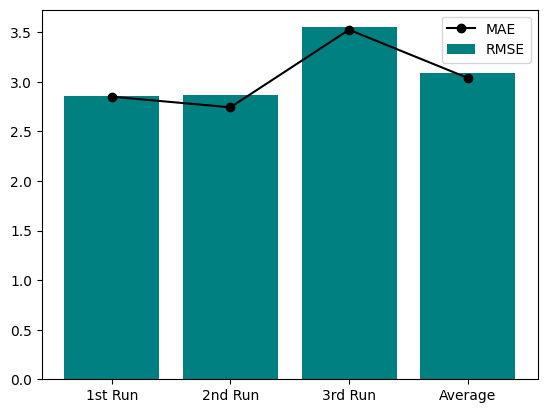

In [314]:
import matplotlib.pyplot as plt
import numpy as np

meanrmse = [2.853944638566067, 2.869544513382867, 3.55, 3.0911630506496444]
meanmae = [2.85 , 2.742857142857143, 3.5250000000000004, 3.0392857142857146]

runs = ("1st Run", "2nd Run", "3rd Run", "Average")
x_axis = runs #for the x-coordinates for the graph
y_axis = meanrmse
y_axis_mae = meanmae

plt.bar(x_axis, y_axis, label = "RMSE", color = "teal")
plt.plot(x_axis, y_axis_mae, label = "MAE", marker='o', color = "black") #marker = 'o' used to 
#plt.show() #having trouble showing this so saved as PNG file instead
plt.legend() #add a legend

plt.savefig("rmsemaeresults_TFIDF.png") #mae is represented by the line graph and rmse by the bars